<a href="https://colab.research.google.com/github/HedersonSantos/Noticias/blob/main/clusterizacaoNoticias_ngrams_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from multiprocessing import Pool, Process
import multiprocessing as mp
from sklearn.pipeline import make_pipeline
from google.colab import files, drive
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import nltk, re
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, ward, fcluster, single, complete, average
import scipy.cluster.hierarchy as sch

# Obtendo dataset de noticias tratadas em preProcessamento_noticias

In [3]:
#!rm news.*
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/news.zip
#!unzip news.zip
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks/nlp_tcc/
!ls -lh 


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/nlp_tcc
total 1.2G
drwx------ 3 root root 4.0K Jul 31 20:13 amostra_news_integrada
-rw------- 1 root root 481M Jul 24 17:03 articles.csv
drwx------ 2 root root 4.0K Jul 31 17:49 bertimbau_base_results
drwx------ 2 root root 4.0K Jul 31 19:09 bertimbau_test
-rw------- 1 root root  93M Jul 24 15:58 news.csv
-rw------- 1 root root 521M Jul 25 22:30 news_integradas.csv
-rw------- 1 root root  93M Jul 24 15:42 noticia_tratada.csv


In [4]:
mp.cpu_count()

2

# Funções para processamento de Linguagem Natural

In [5]:
def download_pt_stopWords():

  '''download das stopwords '''
  nltk.download('stopwords') #stopwords
  nltk.download('rslp')  #stemming
        
def removeStopWords( texto, excluirWords:list=None):
  '''remove as stopwords do texto. Novas stopwords podem ser adicionadas através da lista excluirWords'''
  naoQueridas = nltk.corpus.stopwords.words('portuguese')
  if not excluirWords==None:
    naoQueridas.extend(excluirWords)
  naoQueridas = list(set(naoQueridas))
  palavras = [i for i in texto.split() if not i.lower() in naoQueridas]
  return (" ".join(palavras))

def aplicaStemming( texto):
  ''' obtém o radical das palavras do vocabulário'''
  stemmer = nltk.stem.RSLPStemmer()
  palavras = []
  for w in texto.split():
      palavras.append(stemmer.stem(w))
  return (" ".join(palavras))

def removeCaracteresNaoDesejados(texto):
  textoLimpo = re.sub(r"http\S+", "", texto)
  textoLimpo = re.sub(r"www\..+\..+", "", texto)
  textoLimpo = re.sub(r"[^a-zA-ZáÁéÉíÍóÓúÚãÃàÀôâÂêÊôÔçÇ ]", "", texto)
  return textoLimpo

def retornaVetorizacao(X,pct_min=1, pct_max=1, n_grams=(1,1), excluirSW:list=None):
  ''' monta a matriz sparsa com o índice de vocabulário em cada texto. 
    Retorna a matriz sparsa e o vocabulário '''
  count_vect = CountVectorizer(min_df=pct_min, max_df=pct_max, lowercase=True,stop_words=excluirSW, ngram_range=n_grams) 
  matriz_sparsa = count_vect.fit_transform(X)
  vocabulario = count_vect.fit(X)
  return [matriz_sparsa,count_vect]

def retornaMatriztfIdf(V):
    ''' em cada documento, calcula o tf-idf de cada palavra
        term frequency - inverse document frequency'''
    tfidf_transformer = TfidfTransformer()
    matriz_tfidf = tfidf_transformer.fit_transform(V)
    return matriz_tfidf

def normalizaEreduzDimensionalidadecomPCA( X, nro_dimensao,UT=None):
    data_pca= TruncatedSVD(nro_dimensao)
    if UT==None:
        UT = data_pca.fit(X)
    X_pca =  UT.fit_transform(X)
      
    return [UT,X_pca]

def padronizaValores(X):
  X_norm = StandardScaler(with_mean=False).fit_transform(X)
  return X_norm

def retornaPalavras(listaTexto:list):
  words=""
  for i in listaTexto: 
    i = str(i) 
    separate = i.split() 
    for j in range(len(separate)): 
        separate[j] = separate[j].lower() 
  words += " ".join(separate)+" "
  return words
def montaWordCloud(words, n_palavras:int, sw=None):
  wc = WordCloud(width = 400, height = 200, 
                background_color ='black', max_words=n_palavras,
                min_font_size = 10, stopwords = sw).generate(words)
  return wc

def imprimiWordCloud(listaTexto:list, n_palavras:int, cluster:str=None, sw=None):
  words = retornaPalavras(listaTexto)
  wc = montaWordCloud(words, n_palavras, sw)
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wc) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  if not cluster == None:
    plt.title('PALAVRAS PARA O CLUSTER ' + cluster)
  plt.show()

def preProcessaTextos(dfDados):
  download_pt_stopWords()
  dfDados['text'] = dfDados['text'].astype('unicode')
  dfDados['text'] = dfDados['text'].map(removeCaracteresNaoDesejados)
  dfDados['text'] = dfDados['text'].map(removeStopWords)
  dfDados['text'] = dfDados['text'].map(aplicaStemming)
  return dfDados
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: removeCaracteresNaoDesejados(x['text']),axis=1)
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: removeStopWords(x['text']),axis=1)
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: aplicaStemming(x['text']),axis=1)

def PreProcessamentoParalelo(df, n_jobs):
  df_split = np.array_split(df,n_jobs)
  pool = Pool(n_jobs)
  resultado = pool.map(preProcessaTextos, df_split)
  df = pd.concat(resultado, sort=False)
  return df

def processaVetorizacao(dfDados,min_fr=0.01, max_fr=0.7, ngrams=(1,1)):
  X = dfDados['text'].values
  vetores = retornaVetorizacao(X,min_fr,max_fr,ngrams)
  V = vetores[0]
  return V
  

# Prepara dataset para clusterizacao

In [6]:
#dfDados = pd.read_csv('news_integradas.csv')
dfDados = pd.read_csv('./amostra_news_integrada/amostra_4/amostra.csv')
print(dfDados.shape)

(28122, 3)


In [7]:
dfDados = dfDados.sample(frac=0.05)
print(dfDados.shape)

(1406, 3)


In [8]:
dfDados.columns

Index(['text', 'category', 'category_nro'], dtype='object')

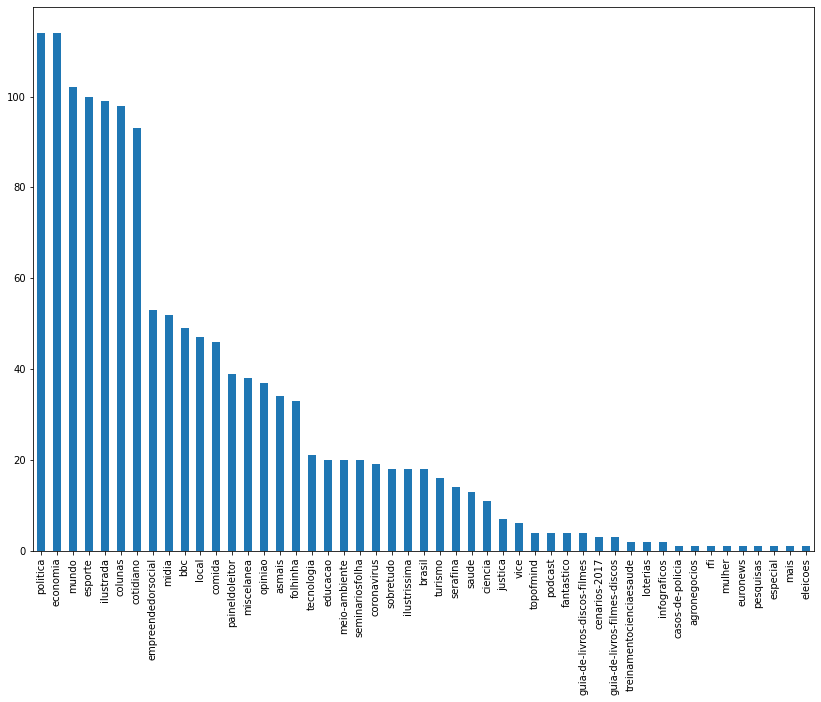

In [9]:
df = dfDados['category'].value_counts()
#df =df.head(40)
df.plot.bar(figsize=(14,10))


In [10]:
#abrir arquivo news.csv
%%time

#dfDados = dfDados.sample(frac=0.2)

dfPreProc = PreProcessamentoParalelo(dfDados,mp.cpu_count())
#dfPreProc = preProcessaTextos(dfDados.copy())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
CPU times: user 211 ms, sys: 73.8 ms, total: 285 ms
Wall time: 24.1 s


In [11]:
print(dfPreProc.shape)
dfPreProc.head()

(1406, 3)


,text,category,category_nro
10361,sob protest opos câm baix parl jap aprov nest quintaf bloc lei modif polít defês país vig desd fim segund guerr mund intuit permit envi trop exteri impulsion primeiroministr shinz abe text reinterpret constitu pacif japon vig desd fim segund guerr mund projet prev envi trop exteri fim apoi país ali princip est unid situ seguranç redor jap cad vez grav diss abe após vot refer chin lei necessár proteg vid japones preven guerr ant explod acrescent med seg agor vot câm alt parl cas recus vot dia projet retorn câm baix ond part abe maior necessár aprovál após termin discurs contr aprov med parlament opos deix plen boicot vot dur noit milh pesso reun próx parl protest contr lei seguranç pesquis opin demonstr cerc japones ve med bom olh maior consid fer constitu país emb constitu jap autoriz uso forç milit soment situaç risc seguranç nacion trop país fim humanit mant sul iraqu legal oper govern ent premi junichir koizum aprov dezembr lei sobr envi trop iraqu époc med sofr resist opos opin públic,mundo,4
6881,sen cpi futebol aprov tard dest quartaf convoc marc pol del ner presid licenci cbf ricard teix comand entidad dua déc convoc aprov sen dat depo aind fech parlament del ner afast carg desd dezembr fbi acus ser benefici esquem receb propin vend direit tornei país exteri investig comit étic fif depo sen vão quest detalh negóci feit cartol empres wagn abrah dep cpi além supost cont dirig exteri sess dest quart sen aprov convoc depo marc pol del ner filh gustav feijó vicepresid cbf del ner filh dep esclarec séri negóci realiz junt pai abril folh revel presid licenci cbf filh compr abrah r milh cobert dúplex metr quadr barr tijuc zon nobr rio apart pertenc empr filh abrah acord del ner filh repass empres cerc r mil sald dev revel outr cobert condomíni imóvel val mín cerc r milh acord corre carioc especi apart lux negoci consid suspeit presid cpi sen rom psbrj banc bol banc bol decid reag sen trê hor cpi futebol aprov convoc marc pol del ner ricard teix dep sen cir nogu ppp ped presid renan calh pmdb cancel sess nogu aleg falt quorum vot cpi moment seil sen assin comparec sess apen trê sal randolf rodrig redeap rom psbrj zezé perrel ptbmg gost solic investig esclarec ocorr cpi futebol hoj cpi presenç sen assin list presenç vot convoc vár pesso solicit cancel dest vot afirm nogu princip ali cbf comiss nogu receb ajud financ entidad ele confeder doou r mil campanh deput feder calh ped rápid investig proced regiment diss decidir nest quint sobr tem ali polít calh gustav feijó vic cbf nest quart aprov convoc dep cpi futebol troc mens obt comiss feijó ped cerc r mil del ner cartol respond envi cbf del ner aparec doad campanh prefeit boc mat interi alago presid sen receb doaç campanh cbf ganh mil entidad ent presid ricard teix presid cpi sen rom diss proced corret secretár geral mes oportun confer atest autentic assinat vot simból conform autoriz reg intern sen diss exjog seleç brasil caix doi suspeit us dinh caix doi campanh prefeit boc mat interi alago gustav feijó vai respond question sen sobr supost ajud financ cbf mens troc doi cartol obt sen feijó cobr del ner dinh campanh respost presid licenci cbf diz pag feit document feijó diz orç campanh r declar justiç eleitor ter arrecad receit r mil cbf aparec doad campanh segund tse dirig eleit prefeit boc mat requer aprov cpi convoc cartol empres ped sen randolf rodrig red,esporte,3
14042,paul format difer temper alh alecrim algum difer dess porç batat frit conf seleç endereç gener prim burg rechonchud batat lembr format waffl tir entrelaç r r joaquim flori itaim bib tel burg tabl batat cas rús r frit casc temper alh alecrim r gabriel dannunzi camp bel reg sul tel achap cort gom têm assinat marc mccain porç rús casc alecrim sai r r hei peixot cambuc reg centr tel,local,7
12885,ótim part futebol ganh derr minut qual sublim corr mil metr sprint magníf últ volt assim ritm mil outon jacob zoet david mitchell traduz forç flu daniel gal temp vir sécul cen orient ext

In [12]:
#dfPreProc.to_csv('./amostra_news_integrada/amostra_4/dfPreProc.csv',index=False)
#dfPreProc = pd.read_csv('./amostra_news_integrada/amostra_4/dfPreProc.csv')
#dfPreProc['text'] = dfPreProc['text'].astype('unicode')

In [13]:
V = processaVetorizacao(dfPreProc,min_fr=0.01, max_fr=0.9, ngrams=(1,2))
X_tfidf = retornaMatriztfIdf(V)

In [14]:
%%time
#https://www.kaggle.com/tchainzzz/agglomerative-document-clustering-on-cord-19

dist = 1 - cosine_similarity(X_tfidf)
dist = dist - dist.min()
linkage_matrix = average(dist) #ward(dist)

CPU times: user 1.52 s, sys: 3.56 ms, total: 1.52 s
Wall time: 1.52 s


* https://towardsdatascience.com/breaking-down-the-agglomerative-clustering-process-1c367f74c7c2
* https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019
* https://medium.com/@gilneyjnr/qualidade-de-agrupamentos-ci%C3%AAncia-de-dados-4b1176bef5e5


In [15]:
#X = np.ones((X_tfidf.shape))
#X_tfidf.toarray(out=X)


In [ ]:
%%time
plt.figure(figsize=(16, 30))
dendrogram = sch.dendrogram(linkage_matrix)
plt.show()

Similaridade Coseno

In [ ]:
X_cosine = X_tfidf.toarray()
print(np.where(~X_cosine.any(axis=1))[0])
z = np.where(~X_cosine.any(axis=1))[0]
for i in z:
  X_cosine[i] = np.ones(X_cosine[i].shape)*1/100
print(np.where(~X_cosine.any(axis=1))[0])

Para 6 clusters

In [ ]:
#model= AgglomerativeClustering(n_clusters=8, affinity='manhattan', linkage='average')
#dfDadosPred = aplicaModelo(model, dfDados, X_tfidf)
model= AgglomerativeClustering(n_clusters=6, affinity='cosine', linkage='average')
y_pred = model.fit_predict(X_cosine)

In [ ]:
dfDados['y_pred'] = y_pred
dfconta = dfDados.groupby(y_pred)['category_nro'].count().reset_index().rename(columns={'index':'y_pred','category_nro':'qtd'}).sort_values(by='qtd', ascending=False)
plt.bar('y_pred','qtd',data=dfconta)


In [ ]:
dfconta = dfDados['y_pred'].value_counts().reset_index()
sw = nltk.corpus.stopwords.words('portuguese')
for y in dfconta['index'].tolist():
  dftmp = dfDados.loc[:,['text']][dfDados['y_pred']==y]
  imprimiWordCloud(dftmp['text'].tolist(),200,str(y),sw)

Para 12 Clusters

In [ ]:
model= AgglomerativeClustering(n_clusters=12, affinity='cosine', linkage='average')
y_pred = model.fit_predict(X_cosine)

In [ ]:
dfDados['y_pred'] = y_pred
dfconta = dfDados.groupby(y_pred)['category_nro'].count().reset_index().rename(columns={'index':'y_pred','category_nro':'qtd'}).sort_values(by='qtd', ascending=False)
plt.bar('y_pred','qtd',data=dfconta)


In [ ]:
dfDados[dfDados['y_pred']==0][['category','y_pred']].groupby('category').count().reset_index().rename(columns={'y_pred':'qtd'}).sort_values(by='qtd', ascending=False)

In [ ]:
dfDados[dfDados['y_pred']==0].sample(10)